# Geospatial Data Plotting

The Cyclist Crash Data includes gespatial data.

These are the coordinates (lattitude and longitude) of the location of the accident.

Investigating the geospatial data can reveal different patterns about the accidents. 
## Where did the most accidents occur?
If you were deciding where to put funding into road safety, knowing where the accidents occur is very important. Being able to display this on a map helps us to direct funding for road safety strategies to where it is needed most.

Showing people where accidents occur may help raise awareness about road safety. If an area is seen as dangerous, locals may campaign for improved road safety.

Location data is very useful.

How do we work with the location data?

---
## Imports and Installs

We need more libraries than Google Colab shares with us normally.

We even need to install some fundamental software packages.

For our purposes we need:
1. pyproj
2. geopandas
3. geoplot

These libraries have other dependencies. Run the following code to ensure all libraries are installed correctly.


In [4]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install pyproj
!pip install geopandas
!pip install geoplot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 232 kB in 1s (207 kB/s)
Selecting previously unselected package libproj-dev:amd64.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-

## Import Libraries
Now we can do our imports

And connect to Google Drive to get the data

In [0]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import geoplot as gplt
import geoplot.crs as gcrs

import requests
# requests enables us to get data directly from a URL or web api


# Read the CSV Data

This is the same dataset that we used for the last exercise.

We are going to make some changes. First, we will add a computed column called "CasScale" - as we need a for casualties which is always above zero.


In [6]:
#read in the ACT Pedestrian Crash Data
req = requests.get('https://www.data.act.gov.au/resource/n2kg-qkwj.csv')
req.text


'"crash_id","crash_date","crash_time","severity","crash_type","cyclists","cyclist_casualties","reported_location","latitude","longitude","location_1"\n"1195124","2018-10-31T08:42:00.000","08:42","Injury","Right angle collision","1","1","KING GEORGE/LANGTON INTERSECTION","-35.300163","149.127264","(-35.300163, 149.127264)"\n"1186777","2018-06-22T12:30:00.000","12:30","Injury","Other - Vehicle to Vehicle","1","1","RAYMOND STREET (HANNAN -> HOBSON)","-35.257239","149.15282","(-35.257239, 149.15282)"\n"1212158","2019-08-02T12:00:00.000","12:00","Injury","Other - Vehicle to Vehicle","1","1","FAWKNER STREET (FARRER -> ELOUERA)","-35.272927","149.135539","\n,  \n(-35.272927, 149.135539)"\n"1195196","2018-11-01T11:00:00.000","11:00","Injury","Right angle collision","1","1","MURDOCH/NORTHBOURNE INTERSECTION","-35.252666","149.133305","(-35.252666, 149.133305)"\n"1186930","2018-06-27T09:00:00.000","09:00","Injury","Other - Vehicle to Vehicle","1","1","GUNGAHLIN/SANDFORD INTERSECTION","-35.218244

In [0]:
#read in the ACT Pedestrian Crash Data
act_data = pd.read_csv('https://www.data.act.gov.au/resource/n2kg-qkwj.csv',parse_dates=["crash_date"])
act_data['cas_scale'] = act_data['cyclist_casualties'] + 1
# We now have a variable called act_data which references a Pandas DataFrame

Check the import!

In [15]:
#display the first 5 entries

act_data.head()

,crash_id,crash_date,crash_time,severity,crash_type,cyclists,cyclist_casualties,reported_location,latitude,longitude,location_1,cas_scale
0,1195124,2018-10-31 08:42:00,08:42,Injury,Right angle collision,1,1,KING GEORGE/LANGTON INTERSECTION,-35.300163,149.127264,"(-35.300163, 149.127264)",2
1,1186777,2018-06-22 12:30:00,12:30,Injury,Other - Vehicle to Vehicle,1,1,RAYMOND STREET (HANNAN -> HOBSON),-35.257239,149.152820,"(-35.257239, 149.15282)",2
2,1212158,2019-08-02 12:00:00,12:00,Injury,Other - Vehicle to Vehicle,1,1,FAWKNER STREET (FARRER -> ELOUERA),-35.272927,149.135539,"\n, \n(-35.272927, 149.135539)",2
3,1195196,2018-11-01 11:00:00,11:00,Injury,Right angle collision,1,1,MURDOCH/NORTHBOURNE INTERSECTION,-35.252666,149.133305,"(-35.252666, 149.133305)",2
4,1186930,2018-06-27 09:00:00,09:00,Injury,Other - Vehicle to Vehicle,1,1,GUNGAHLIN/SANDFORD INTERSECTION,-35.218244,149.130995,"(-35.218244, 149.130995)",2


## Data Wrangling
Now we will start "wrangling" our data.

We will change column names, drop **Crash ID**, and extract **Latt**itude and **Long**itude from **Location** by removing brackets, spaces, and splitting on the comma.

We will also create a **SevIndex** column which represents the severity as a number.
0. Property Damage Only
1. Injury
2. Fatal


In [0]:
#Tidy up the column names

act_data = act_data.rename(index=str, columns={
    "cyclist_casualties": "casualties"
    })
act_data.drop(columns=['crash_id'], inplace=True)
act_data.head()
severities = ['Property Damage Only', 'Injury', 'Fatal']
act_data['sev_index'] = act_data.severity.map(lambda x: severities.index(x))

---
> ### Custom Fades
> The following code creates a column for each year+month combination with a computed value for the fade out.
> This is used for an animation.
---

In [0]:
def custom_fade(cd, sev, yy, mm):
  fade_factor = 0
  if sev == 2:
    return 1.0
  elif sev == 1:
    fade_factor = 0.95
  else:
    fade_factor = 0.85
  crash_date = datetime.datetime.strptime(cd, "%Y-%m-%d")
  fd = '20' + str(yy) + '-' + f'{mm:02}' + '-' + '01'
  fade_date = datetime.datetime.strptime(fd, "%Y-%m-%d")
  if fade_date < crash_date:
    return 1.0
  else:
    day = datetime.timedelta(days=1)
    td = (fade_date - crash_date)/day # should convert to days
    months_between = td / 30.0
    return fade_factor ** months_between

for yy in range(12,20):
  for mm in range(1, 13):
    col_name = 'Fad' + f'{yy:02}' + f'{mm:02}'
    act_data[col_name] = act_data.apply(lambda x: custom_fade(cd=x.crash_date.strftime('%Y-%m-%d'),sev=x.sev_index,yy=yy,mm=mm), axis=1)



Inspect the dataframe to check your work!

In [19]:
act_data.head()

,crash_date,crash_time,severity,crash_type,cyclists,casualties,reported_location,latitude,longitude,location_1,cas_scale,sev_index,Fad1201,Fad1202,Fad1203,Fad1204,Fad1205,Fad1206,Fad1207,Fad1208,Fad1209,Fad1210,Fad1211,Fad1212,Fad1301,Fad1302,Fad1303,Fad1304,Fad1305,Fad1306,Fad1307,Fad1308,Fad1309,Fad1310,Fad1311,Fad1312,Fad1401,Fad1402,Fad1403,Fad1404,...,Fad1609,Fad1610,Fad1611,Fad1612,Fad1701,Fad1702,Fad1703,Fad1704,Fad1705,Fad1706,Fad1707,Fad1708,Fad1709,Fad1710,Fad1711,Fad1712,Fad1801,Fad1802,Fad1803,Fad1804,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,Fad1901,Fad1902,Fad1903,Fad1904,Fad1905,Fad1906,Fad1907,Fad1908,Fad1909,Fad1910,Fad1911,Fad1912
0,2018-10-31 08:42:00,08:42,Injury,Right angle collision,1,1,KING GEORGE/LANGTON INTERSECTION,-35.300163,149.127264,"(-35.300163, 149.127264)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.998292,0.948377,0.899419,0.852989,0.813115,0.771139,0.732582,0.694764,0.660026,0.625954,0.593640,0.563958,0.534845,0.508103
1,2018-06-22 12:30:00,12:30,Injury,Other - Vehicle to Vehicle,1,1,RAYMOND STREET (HANNAN -> HOBSON),-35.257239,149.152820,"(-35.257239, 149.15282)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.984730,0.933895,0.885685,0.841401,0.797965,0.758067,0.718933,0.681820,0.649948,0.616395,0.585576,0.555346,0.527579,0.500344,0.474515,0.450789,0.427518,0.406142
2,2019-08-02 12:00:00,12:00,Injury,Other - Vehicle to Vehicle,1,1,FAWKNER STREET (FARRER -> ELOUERA),-35.272927,149.135539,"\n, \n(-35.272927, 149.135539)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.902500,0.855910,0.813115
3,2018-11-01 11:00:00,11:00,Injury,Right angle collision,1,1,MURDOCH/NORTHBOURNE INTERSECTION,-35.252666,149.133305,"(-35.252666, 149.133305)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.900958,0.854448,0.814506,0.772459,0.733836,0.695953,0.661156,0.627025,0.594656,0.564923,0.535760,0.508972
4,2018-06-27 09:00:00,09:00,Injury,Other - Vehicle to Vehicle,1,1,GUNGAHLIN/SANDFORD INTERSECTION,-35.218244,149.130995,"(-35.218244, 149.130995)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.993184,0.941913,0.893289,0.848624,0.804816,0.764575,0.725106,0.687674,0.655528,0.621687,0.590603,0.560114,0.532109,0.504640,0.478589,0.454659,0.431188,0.409629


Here is an example fade formula (80% fade after 2 months and 10 days)

In [20]:
(0.8 ** 2.333)

0.5941675639456073

## Zip Coordinates For Conversion
Zipping combines *iterators* returning a new *iterator* of *tuples*.

You can view the result below

In [23]:
#Pull the coordinates out into a list of tuples for conversion
#from longtitude/latitude to GDA94 / MGA zone 55 projection

zipped_coordinates = list(zip(act_data['longitude'], act_data['latitude']))

zipped_coordinates[0:5]

[(149.127264, -35.300163),
 (149.15282, -35.257239),
 (149.135539, -35.272927),
 (149.133305, -35.252666),
 (149.13099499999998, -35.218244)]

# Coordinate Systems

Geospatial data (which I referred to as "Lattitude" and "Longitude" above) is not as simple as Latt and Long. 

Coordinates are referenced by a system of structured data transformation mappng real world space into a 2D structure (sometimes) or a 3D surface (in other cases).

The data in the ACT Pedestrian Crash data spreadsheet are recorded in a coordinate system known as **WGS84** or [**EPSG:4326**](https://epsg.io/4326).

The coordinate system for our ACT map data is in format **GDA94** or [**EPSG:28355**](https://epsg.io/28355)

EPSG:4326 and EPSG:28355 are **Coordinate Reference Systems (CRS)**. We will use the EPSG:28355 CRS for our plotting.

The **pyproj** library includes a utility to transform coordinates from one system to another system

We will transform our coordinates for use in the plotting process.

In [24]:
#Convert into a new list of tuples

epsg4326 = pyproj.Proj(init='epsg:4326')
epsg28355 = pyproj.Proj(init='epsg:28355')

convert_coordinates = []

for x, y in zipped_coordinates:
    convert_coordinates.append(pyproj.transform(epsg4326,epsg28355,x,y))
    
convert_coordinates[:5]


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


[(693419.7141009108, 6091593.737612726),
 (695847.1132004821, 6096305.009161098),
 (694237.3078836693, 6094598.769416415),
 (694082.4175432681, 6096850.632401869),
 (693954.1985705688, 6100673.4566695895)]

Create a CRS variable, and establish the bounds of our coordinate system for our plot (min_x, min_y, max_x, max_y)

In [0]:
#create crs (Coodinate Refence System) variable for GeoDataFrame

crs = {'init': 'epsg:28355'}

# save the minimum and maximum coordinates for use 
# in limiting the axes - as we plot roads (larger) as well as pedestrian
# crash incidents
min_x = min([x for x,y in convert_coordinates])
min_y = min([y for x,y in convert_coordinates])
max_x = max([x for x,y in convert_coordinates])
max_y = max([y for x,y in convert_coordinates])

# Geometry

The converted coordinates need to be transformed *again* into Shapely Geometry.

In [26]:
#create geometry variable for GeoDataFrame

geometry = [Point(x, y) for x, y in convert_coordinates]

geometry[0:5]

# GeoDataFrame

Pandas has DataFrames
GeoPandas has GeoDataFrames

GeoDataFrames combine Pandas DataFrames with a coordinate reference system and a Shapely Geometry Point for each row of data

In [27]:
#create GeoDataFrame
act_geo_df = gpd.GeoDataFrame(act_data, crs=crs, geometry=geometry)
act_geo_df.head()



,crash_date,crash_time,severity,crash_type,cyclists,casualties,reported_location,latitude,longitude,location_1,cas_scale,sev_index,Fad1201,Fad1202,Fad1203,Fad1204,Fad1205,Fad1206,Fad1207,Fad1208,Fad1209,Fad1210,Fad1211,Fad1212,Fad1301,Fad1302,Fad1303,Fad1304,Fad1305,Fad1306,Fad1307,Fad1308,Fad1309,Fad1310,Fad1311,Fad1312,Fad1401,Fad1402,Fad1403,Fad1404,...,Fad1610,Fad1611,Fad1612,Fad1701,Fad1702,Fad1703,Fad1704,Fad1705,Fad1706,Fad1707,Fad1708,Fad1709,Fad1710,Fad1711,Fad1712,Fad1801,Fad1802,Fad1803,Fad1804,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,Fad1901,Fad1902,Fad1903,Fad1904,Fad1905,Fad1906,Fad1907,Fad1908,Fad1909,Fad1910,Fad1911,Fad1912,geometry
0,2018-10-31 08:42:00,08:42,Injury,Right angle collision,1,1,KING GEORGE/LANGTON INTERSECTION,-35.300163,149.127264,"(-35.300163, 149.127264)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.998292,0.948377,0.899419,0.852989,0.813115,0.771139,0.732582,0.694764,0.660026,0.625954,0.593640,0.563958,0.534845,0.508103,POINT (693419.714 6091593.738)
1,2018-06-22 12:30:00,12:30,Injury,Other - Vehicle to Vehicle,1,1,RAYMOND STREET (HANNAN -> HOBSON),-35.257239,149.152820,"(-35.257239, 149.15282)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.984730,0.933895,0.885685,0.841401,0.797965,0.758067,0.718933,0.681820,0.649948,0.616395,0.585576,0.555346,0.527579,0.500344,0.474515,0.450789,0.427518,0.406142,POINT (695847.113 6096305.009)
2,2019-08-02 12:00:00,12:00,Injury,Other - Vehicle to Vehicle,1,1,FAWKNER STREET (FARRER -> ELOUERA),-35.272927,149.135539,"\n, \n(-35.272927, 149.135539)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.902500,0.855910,0.813115,POINT (694237.308 6094598.769)
3,2018-11-01 11:00:00,11:00,Injury,Right angle collision,1,1,MURDOCH/NORTHBOURNE INTERSECTION,-35.252666,149.133305,"(-35.252666, 149.133305)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.900958,0.854448,0.814506,0.772459,0.733836,0.695953,0.661156,0.627025,0.594656,0.564923,0.535760,0.508972,POINT (694082.418 6096850.632)
4,2018-06-27 09:00:00,09:00,Injury,Other - Vehicle to Vehicle,1,1,GUNGAHLIN/SANDFORD INTERSECTION,-35.218244,149.130995,"(-35.218244, 149.130995)",2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.993184,0.941913,0.893289,0.848624,0.804816,0.764575,0.725106,0.687674,0.655528,0.621687,0.590603,0.560114,0.532109,0.504640,0.478589,0.454659,0.431188,0.409629,POINT (693954.199 6100673.457)


> ### GeoDataFrames are DataFrames
> Just for demonstration purposes - you can manipulate GeoDataFrames in the same ways as DataFrames
>
> The example below shows 2 ways of querying a date column


In [28]:
# compare_date = datetime.datetime(2012,3,1,0,0,0)
# act_geo_filt = act_geo_df[act_geo_df.crash_date < compare_date]
ts = pd.Timestamp
act_geo_filt = act_geo_df.query('crash_date < @ts("20130301T071320")') 
act_geo_filt.head()


,crash_date,crash_time,severity,crash_type,cyclists,casualties,reported_location,latitude,longitude,location_1,cas_scale,sev_index,Fad1201,Fad1202,Fad1203,Fad1204,Fad1205,Fad1206,Fad1207,Fad1208,Fad1209,Fad1210,Fad1211,Fad1212,Fad1301,Fad1302,Fad1303,Fad1304,Fad1305,Fad1306,Fad1307,Fad1308,Fad1309,Fad1310,Fad1311,Fad1312,Fad1401,Fad1402,Fad1403,Fad1404,...,Fad1610,Fad1611,Fad1612,Fad1701,Fad1702,Fad1703,Fad1704,Fad1705,Fad1706,Fad1707,Fad1708,Fad1709,Fad1710,Fad1711,Fad1712,Fad1801,Fad1802,Fad1803,Fad1804,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,Fad1901,Fad1902,Fad1903,Fad1904,Fad1905,Fad1906,Fad1907,Fad1908,Fad1909,Fad1910,Fad1911,Fad1912,geometry
39,2012-09-25 07:43:00,07:43,Injury,Right turn into oncoming vehicle,1,1,DRAKEFORD/HURTLE INTERSECTION,-35.433980,149.088006,"(-35.43398, 149.088006)",2,1,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.989794,0.938698,0.891763,0.845727,0.802069,0.764575,0.725106,0.688850,0.653290,0.620625,0.588587,0.558202,0.530292,0.502917,0.477771,0.453107,0.429717,0.409629,0.388483,...,0.081411,0.077209,0.073348,0.069562,0.065971,0.062887,0.059640,0.056658,0.053734,0.051047,0.048412,0.045913,0.043617,0.041365,0.039297,0.037268,0.035344,0.033692,0.031953,0.030355,0.028788,0.027349,0.025937,0.024598,0.023368,0.022162,0.021054,0.019967,0.018936,0.018051,1.711914e-02,1.626318e-02,1.542363e-02,1.465245e-02,1.389605e-02,1.317869e-02,1.251976e-02,1.187345e-02,1.127978e-02,POINT (689536.429 6076825.682)
41,2012-08-15 14:30:00,14:30,Property Damage Only,Right angle collision,1,0,DRAKEFORD/JOHNSON/WOODCOCK INTERSECTION,-35.437784,149.091475,"(-35.437784, 149.091475)",1,0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.912019,0.775216,0.655374,0.557068,0.470950,0.398144,0.342109,0.289222,0.245839,0.207834,0.176659,0.149349,0.126261,0.107321,0.090730,0.077121,0.065199,0.055119,0.047362,0.040040,...,0.000283,0.000239,0.000204,0.000172,0.000145,0.000125,0.000106,0.000090,0.000076,0.000065,0.000055,0.000046,0.000039,0.000033,0.000028,0.000024,0.000020,0.000017,0.000015,0.000012,0.000011,0.000009,0.000008,0.000006,0.000005,0.000005,0.000004,0.000003,0.000003,0.000002,2.025163e-06,1.721389e-06,1.455275e-06,1.236984e-06,1.045756e-06,8.840901e-07,7.514766e-07,6.353041e-07,5.400085e-07,POINT (689842.435 6076397.047)
56,2013-01-24 08:30:00,08:30,Injury,Same direction side swipe,1,1,LONDON CIRCUIT (EDINBURGH -> COMMNLONDWRM),-35.283691,149.126281,"(-35.283691, 149.126281)",2,1,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.986415,0.940304,0.891763,0.847175,0.803441,0.763269,0.723867,0.686499,0.652174,0.618507,0.587581,0.557249,0.528482,0.503778,0.477771,...,0.100123,0.094954,0.090206,0.085550,0.081133,0.077341,0.073348,0.069681,0.066084,0.062779,0.059539,0.056465,0.053642,0.050873,0.048329,0.045834,0.043468,0.041436,0.039297,0.037332,0.035405,0.033635,0.031898,0.030252,0.028739,0.027256,0.025893,0.024556,0.023288,0.022200,2.105378e-02,2.000109e-02,1.896857e-02,1.802015e-02,1.708989e-02,1.620766e-02,1.539728e-02,1.460243e-02,1.387231e-02,POINT (693369.516 6093422.848)
60,2012-04-03 08:15:00,08:15,Property Damage Only,Same direction side swipe,1,0,LONDON CIRCUIT (EDINBURGH -> COMMNLONDWRM),-35.283602,149.126230,"(-35.283602, 149.12623)",1,0,1.0,1.0,1.00000,1.000000,0.859259,0.726425,0.617461,0.522006,0.441308,0.375112,0.317123,0.269554,0.227883,0.192654,0.165540,0.139949,0.118956,0.100567,0.085482,0.072267,0.061095,0.051931,0.043903,0.037317,0.031548,0.026671,0.022917,0.019375,...,0.000137,0.000116,0.000098,0.000083,0.000070,0.000060,0.000051,0.000043,0.000037,0.000031,0.000026,0.000022,0.000019,0.000016,0.000014,0.000012,0.000010,0.000008,0.000007,0.000006,0.000005,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,9.799364e-07,8.329459e-07,7.041789e-07,5.985521e-07,5.060206e-07,4.277937e-07,3.636247e-07,3.074111e-07,2.612994e-07,POINT (693365.089 6093432.820)
86,2012

> and this shows a query using SevIndex (2 mean "Fatal")

In [29]:
act_geo_df.query('sev_index == 2')

,crash_date,crash_time,severity,crash_type,cyclists,casualties,reported_location,latitude,longitude,location_1,cas_scale,sev_index,Fad1201,Fad1202,Fad1203,Fad1204,Fad1205,Fad1206,Fad1207,Fad1208,Fad1209,Fad1210,Fad1211,Fad1212,Fad1301,Fad1302,Fad1303,Fad1304,Fad1305,Fad1306,Fad1307,Fad1308,Fad1309,Fad1310,Fad1311,Fad1312,Fad1401,Fad1402,Fad1403,Fad1404,...,Fad1610,Fad1611,Fad1612,Fad1701,Fad1702,Fad1703,Fad1704,Fad1705,Fad1706,Fad1707,Fad1708,Fad1709,Fad1710,Fad1711,Fad1712,Fad1801,Fad1802,Fad1803,Fad1804,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,Fad1901,Fad1902,Fad1903,Fad1904,Fad1905,Fad1906,Fad1907,Fad1908,Fad1909,Fad1910,Fad1911,Fad1912,geometry
68,2018-04-07 09:05:00,09:05,Fatal,Other - Vehicle to Vehicle,1,1,MENTONE/THARWA INTERSECTION,-35.451450,149.091418,"(-35.45145, 149.091418)",2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,POINT (689805.156 6074881.205)
735,2012-09-22 18:10:00,18:10,Fatal,Struck object (Off Road),1,1,FITZHARDINGE CRESCENT (CALLAGHAN -> READ),-35.216563,149.067735,"(-35.216563, 149.067735)",2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,POINT (688199.565 6100981.656)
810,2015-01-29 07:30:00,07:30,Fatal,Overturned (On Road),1,1,KENT STREET (STRICKLAND -> MACARTNEY),-35.318027,149.098266,"(-35.318027, 149.098266)",2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,POINT (690740.734 6089668.358)


# Maps and Context

If we plot our point data with no map, there is no context for where the incident occurred.

If we include a map using the same CRS, then -- as long as viewers can read the map -- the viewer can understand the location, spread and clustering of the data points.

We are going to use data from the [ACT Planning Directorate](https://www.planning.act.gov.au/), showing the centrelines of all roads in the ACT.

--2020-01-29 13:30:20--  http://www.cyclicautomata.com/impactful_ds/ACT_Road_Centrelines.shp
Resolving www.cyclicautomata.com (www.cyclicautomata.com)... 162.241.253.126
Connecting to www.cyclicautomata.com (www.cyclicautomata.com)|162.241.253.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24587172 (23M)
Saving to: ‘ACT_Road_Centrelines.shp.1’

ACT_Road_Centreline 100%[===================>]  23.45M  24.0MB/s    in 1.0s    

2020-01-29 13:30:21 (24.0 MB/s) - ‘ACT_Road_Centrelines.shp.1’ saved [24587172/24587172]

--2020-01-29 13:30:23--  http://www.cyclicautomata.com/impactful_ds/ACT_Road_Centrelines.shx
Resolving www.cyclicautomata.com (www.cyclicautomata.com)... 162.241.253.126
Connecting to www.cyclicautomata.com (www.cyclicautomata.com)|162.241.253.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345684 (338K)
Saving to: ‘ACT_Road_Centrelines.shx’

ACT_Road_Centreline 100%[===================>] 337.58K  1.53MB/s    in 0.2s   

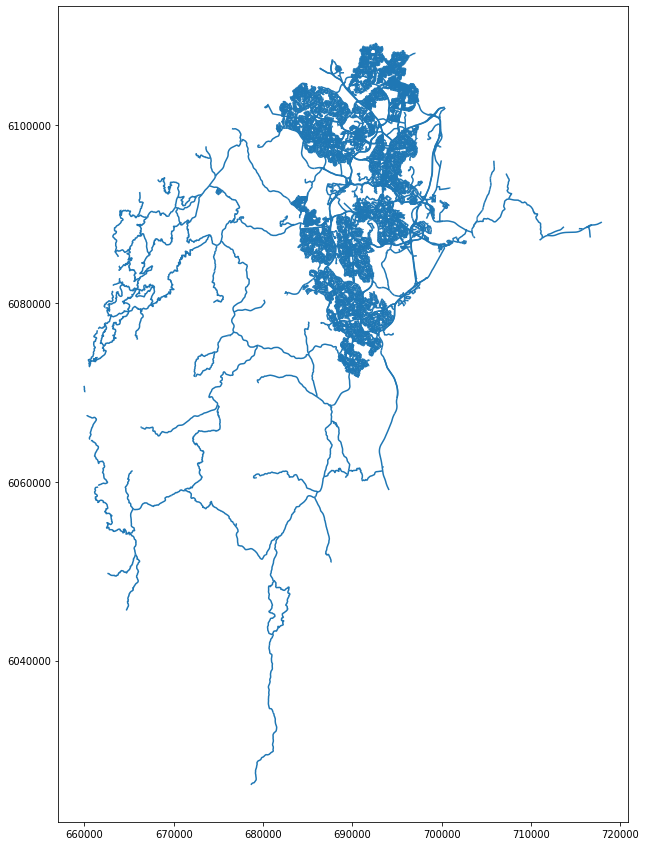

In [34]:
#read in the ACT  using Geopandas read_file
# use wget to get the shapefiles and save them locally
! wget http://www.cyclicautomata.com/impactful_ds/ACT_Road_Centrelines.shp
! wget http://www.cyclicautomata.com/impactful_ds/ACT_Road_Centrelines.shx

# read the shapefile into a geopandas geodataframe
ACT_map_district = gpd.read_file('ACT_Road_Centrelines.shp')
# create an axis for plotting and set the size of the plot
fig,ax = plt.subplots(figsize = (15,15))
# Plot the road centrelines
ACT_map_district.plot(ax = ax)

# Plotting The Data

Here we will plot the dots without context.

Does it make sense?

Can you predict which suburb a dot is located within?

<Figure size 432x288 with 0 Axes>

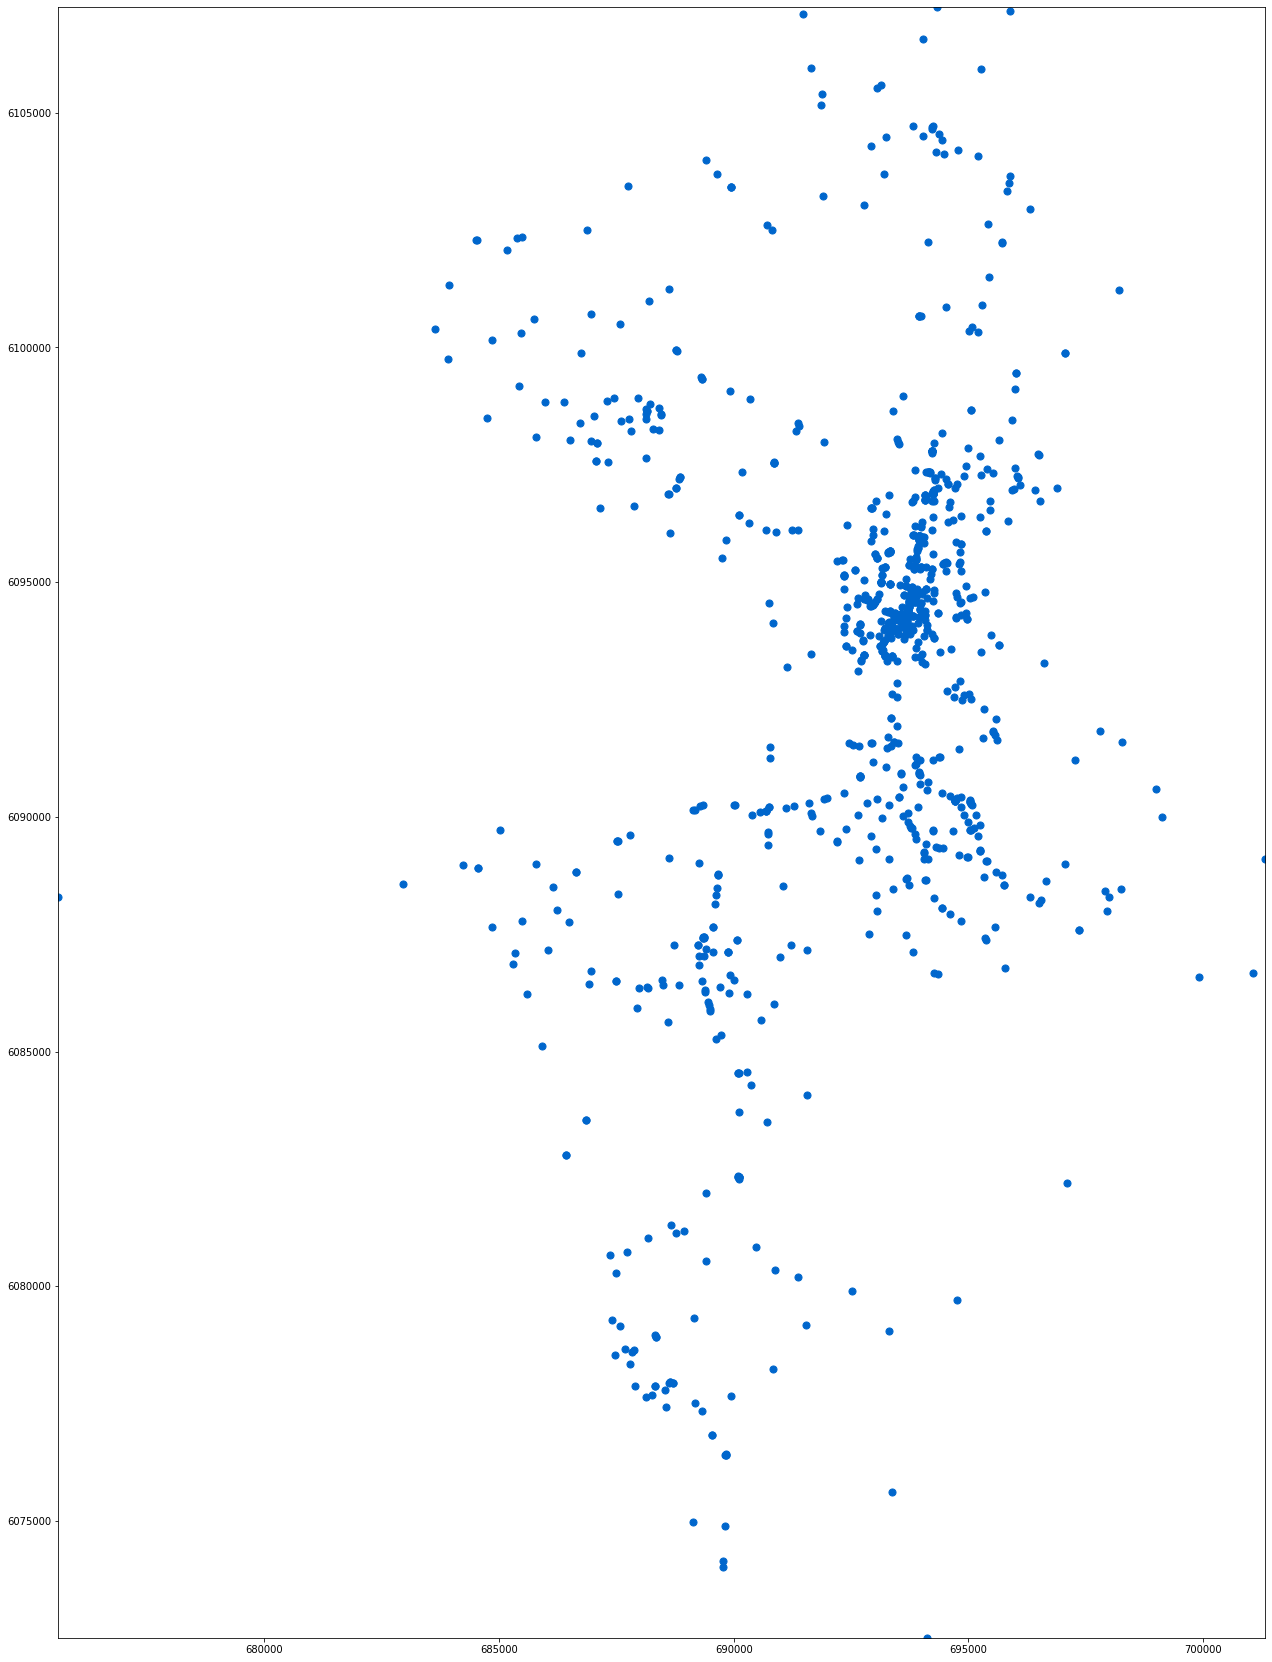

In [35]:
plt.clf()
fig,ax = plt.subplots(figsize=(30,30))
ax.set_xlim(left=min_x, right=max_x)
ax.set_ylim(bottom=min_y, top=max_y)

# plot all cyclist accidents - small blue dots
act_geo_df.plot(
    ax=ax, 
    markersize=50,
    color="#0066CC")


# Plotting with Context

If we plot the dots with the map - then we can understand the location of the map.

Do you recognise the shape of Canberra from its streets?

Does this make more sense?

What is missing from this plot?



<Figure size 432x288 with 0 Axes>

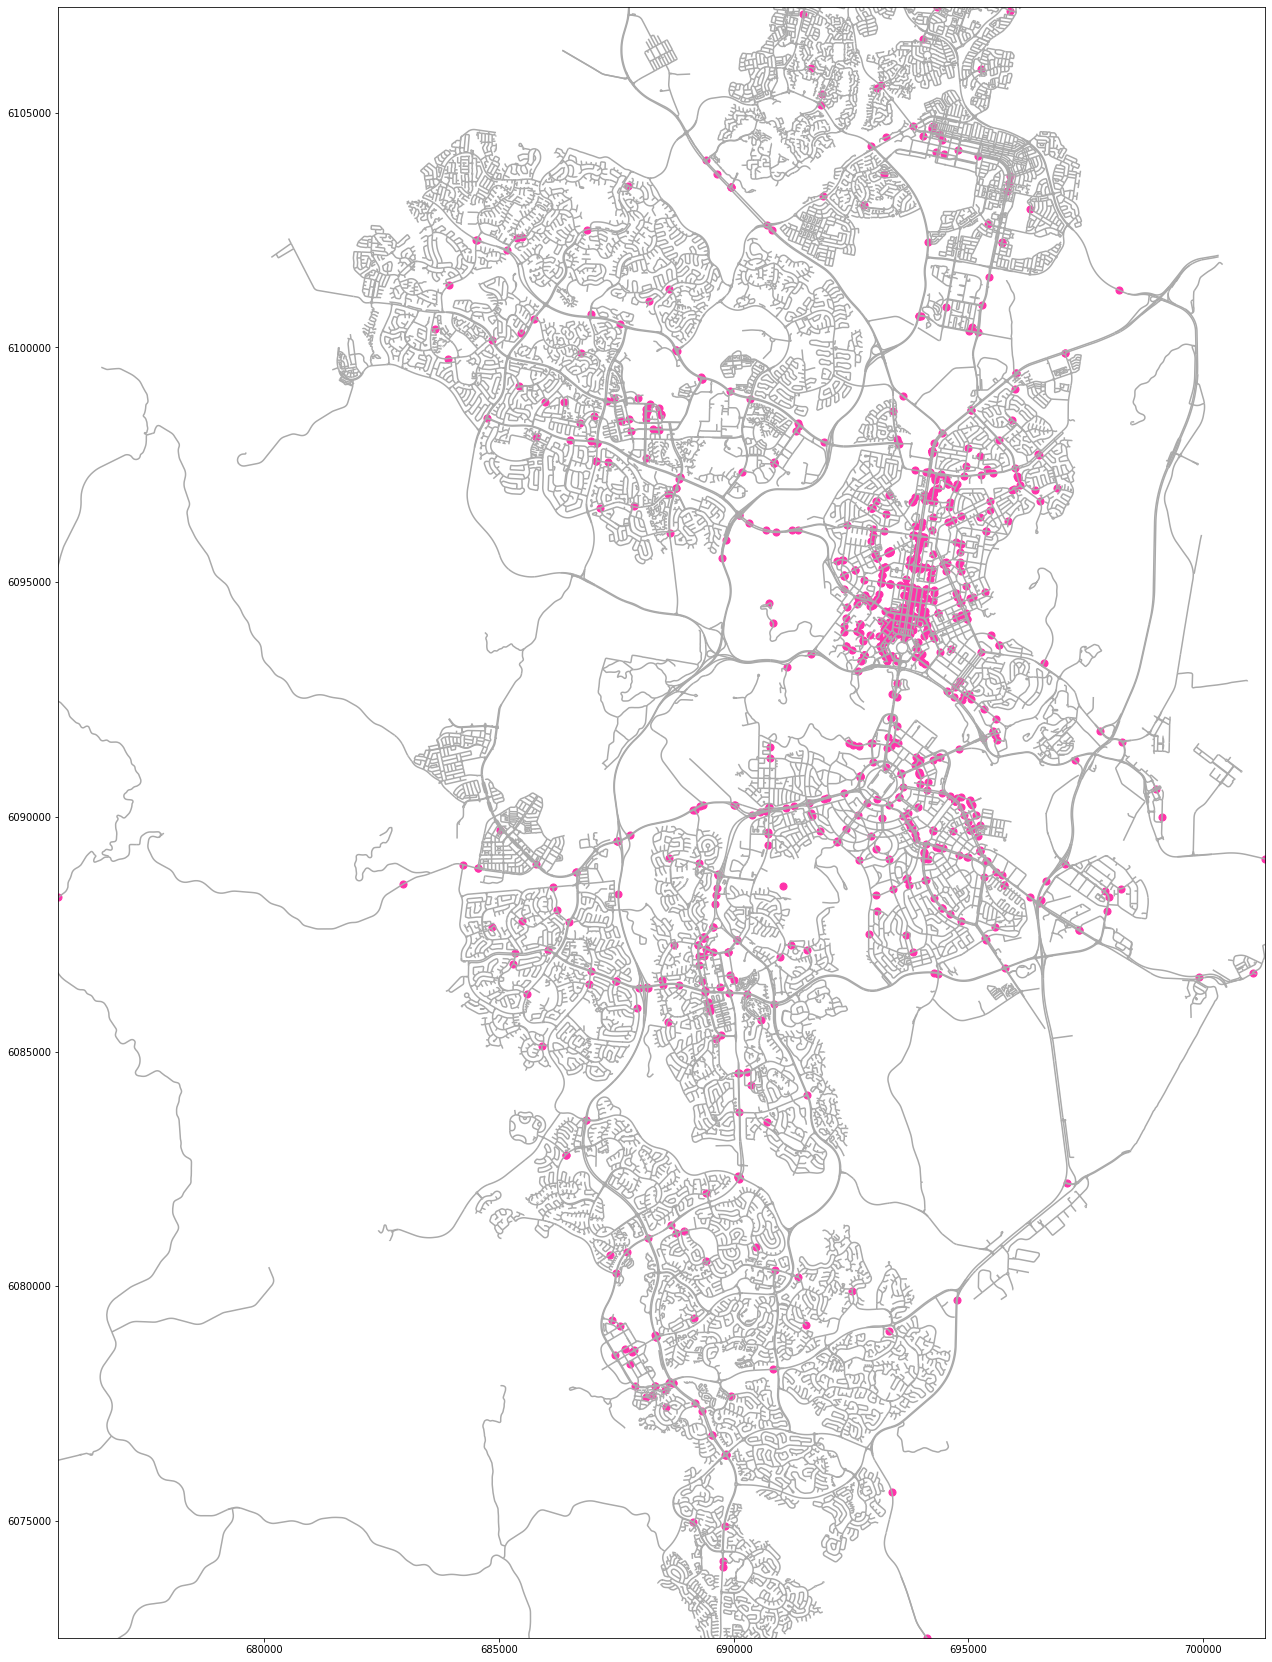

In [36]:
# Clear the plot
plt.clf()
# Get axes and set size
fig,ax = plt.subplots(figsize=(30,30))
# Set the bounds of our axes based on the pedestrian crash data
ax.set_xlim(left=min_x, right=max_x)
ax.set_ylim(bottom=min_y, top=max_y)
# Plot the streets in pale grey
ACT_map_district.plot(ax = ax, color='#AAAAAA')
# plot all pedestrian accidents - small purple dots
act_geo_df.plot(
    ax=ax, 
    markersize=50,
    color="#FF33AA")


# Adding meaning to our dots

It would be better to encode some more meaning into our dots.

This example makes 2 decisions around representation:

1. Colour communicates severity of accident
2. Size communicates the number of people involved in the accident

The code below was written for an animation - and a lot of the "complexity" is about the custom fades for dots.  This will be demonstrated.

In [0]:
# Create a function which builds a query string for the given year, month, 
# severity, number of casualties, alpha fade level (already pre-calculated)
# and a delta (difference from the last alpha)
def alphaQuery(year,month,sevIndex,casualties,alpha,delta=0.1):
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    fad = 'Fad'+yy+mm
    if (sevIndex == 2):
        return '(sev_index == ' + str(sevIndex) + ' and casualties == ' + str(casualties) + ')'' and (' + \
               fad + ' == 1)'
    else:
        return '(sev_index == ' + str(sevIndex) + ' and casualties == ' + str(casualties) + ') and (' + \
               fad + ' <= ' + str(alpha) + ' and ' + fad + ' > ' + str(alpha - delta) + ')'

# Create a function which plots the dots for a gven year, month, severity, and 
# alpha fade value
def plot_yearMonthAlpha(df,ax1,year,month,sev,alpha,colour):
    # Pedestrian Crash Data points have between 1 and 2 casualties
    for casualties in range(0,3):
        # Set the size of the marker based on the number of casualties
        markersize = (casualties + 1) * 100
        # Complete the query
        qr = df.query(alphaQuery(year,month,sev,casualties,alpha,0.1))
        if qr.size > 0:
            # Plot the points
            qr.plot(
                ax=ax1, 
                markersize=markersize,
                color=colour,
                alpha=1.0) # we should use "alpha=alpha"
                # but - I am not doing fades in this version :-)

# Plot the public pedestrian crash data onto the map, and do some styling
# This function plots everything for a given year, month, day
def print_plot_ymd(df, ax1, year, month, day, fileprefix, seq):
    # Format parameters
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    dd = f'{day:02}'
    sn = f'{seq:05}'
    # Create filename
    filename = fileprefix + sn + '.png'
    # Establish dot colours
    i_colour = "#FF9933" # '#FF9900'
    p_colour = "#EE33FF"
    f_colour = "#332200"
    # Make a date for comparison
    compare_date = datetime.datetime(year,month,day,0,0,0)
    # Filter based on crash date and the compare date
    df_filt = df[df.crash_date < compare_date]
    # Create a range of alpha values for processing our alpha queries
    for alpha in np.arange(0.1,1.0,0.1):
        # Plot for Property Damage Only
        plot_yearMonthAlpha(df_filt,ax1,year,month,0,alpha,p_colour)
        # Plot for Injury
        plot_yearMonthAlpha(df_filt,ax1,year,month,1,alpha,i_colour)
    # When finished - plot for Fatal - Fatal will appear on top
    # of other dots - and do not fade
    plot_yearMonthAlpha(df_filt,ax1,year,month,2,alpha,f_colour)
    # plt.savefig(filename,bbox_inches='tight',transparent=True)


# print all images for an animation. One frame every 2 days.
def print_frames(df):
    frame_no = 0
    # For all years
    for year in range(2012,2019):
        # For all months
        for month in range(1,13):
            # For every second day from 2 to 28
            for day in range(2,30,2):
                plt.clf()
                fig,ax = plt.subplots(figsize=(30,30))
                ax.set_xlim(left=min_x, right=max_x)
                ax.set_ylim(bottom=min_y, top=max_y)
                ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
                print_plot_ymd(df,ax,year,month,day,"cycle_crash_",frame_no)
                frame_no += 1


# Make it so - for all frames
# print_frames(act_geo_df)





# Legendary Plots

This final example shows how the data representation can be improved with legends and labels.

It puts it all together.

<Figure size 432x288 with 0 Axes>

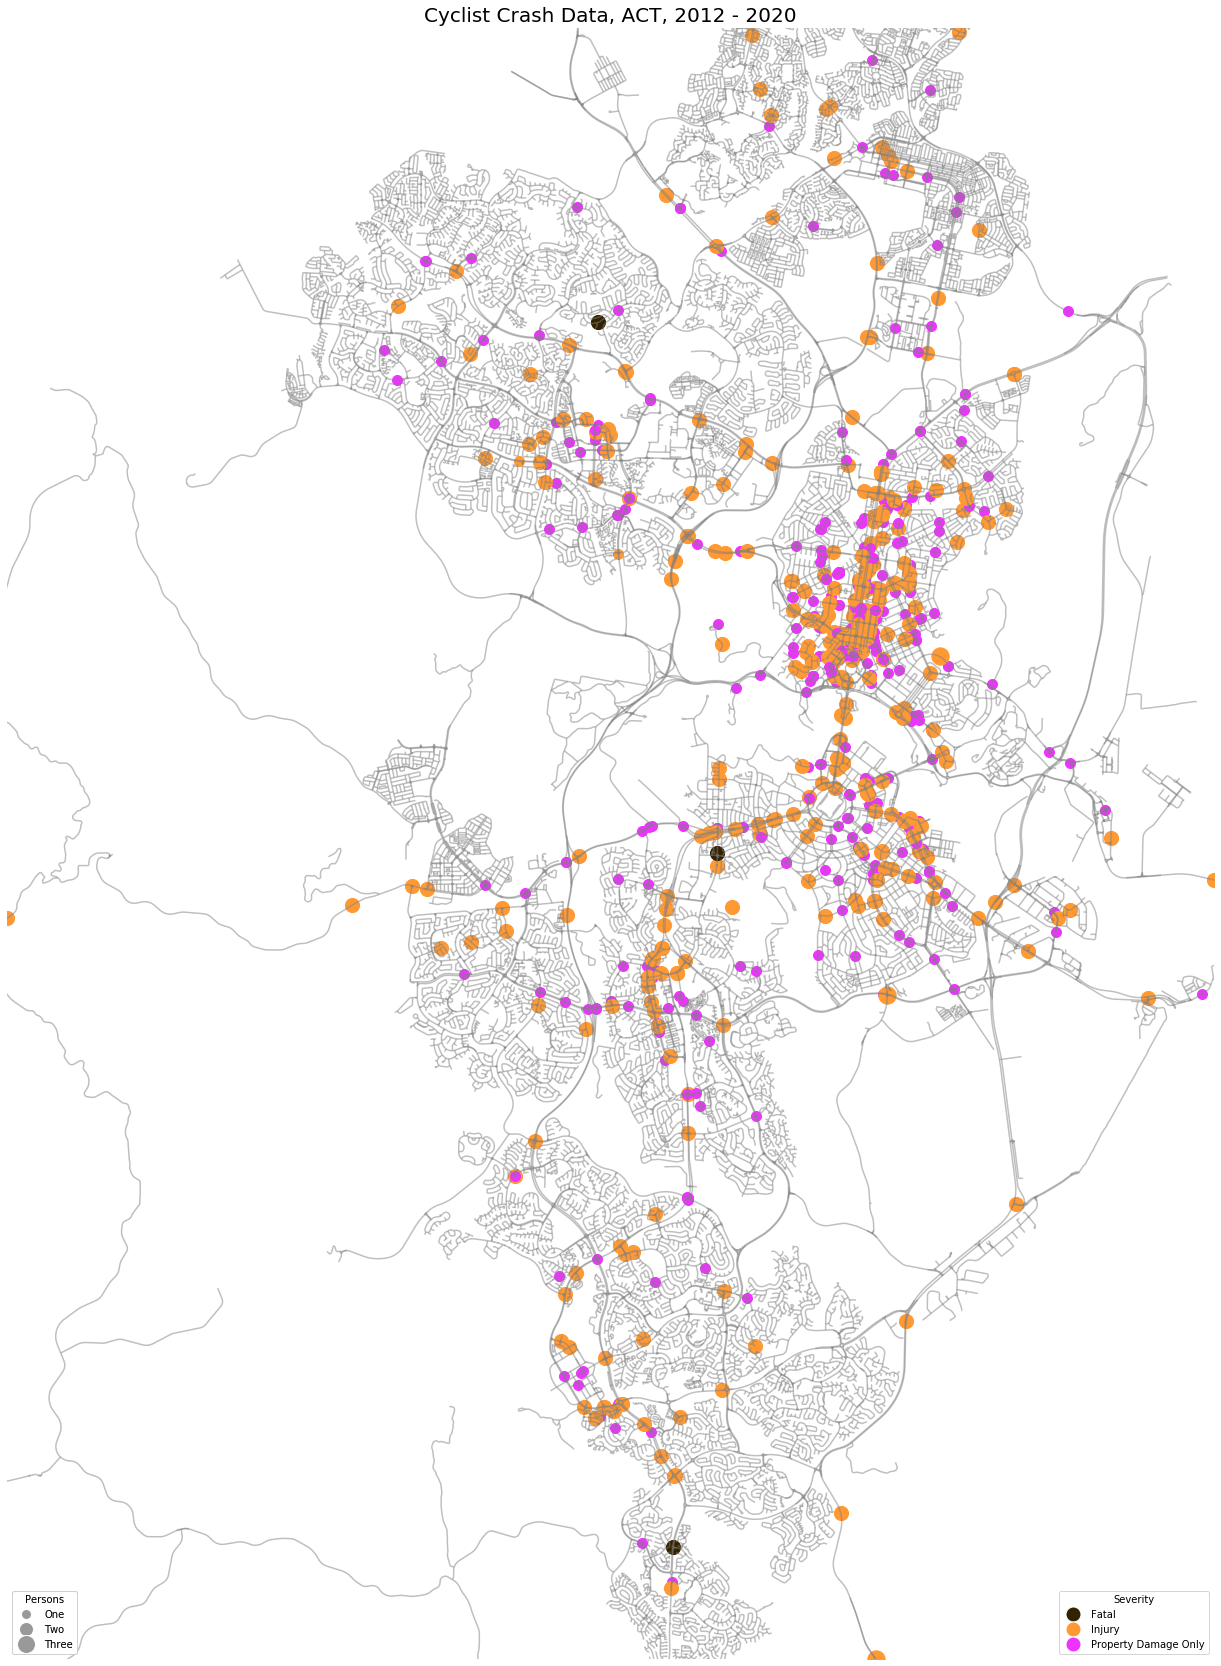

In [40]:
##############################################################################
# Let's plot all dots coded via colour
# Size represents number of casualties

# Clear the plot
plt.clf()
# Get some axes
fig,ax = plt.subplots(figsize=(30,30))
# Set our boundaries
ax.set_xlim(left=min_x, right=max_x)
ax.set_ylim(bottom=min_y, top=max_y)
# Plot the roadlines map
ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
# Turn off the axis tick marks
ax.axis("off")
# Plot all dots up to June 1st 2019 (alpha is ignored)
print_plot_ymd(act_geo_df,ax,2019,6,1,"cycle_crash_",0)
# Set a title
plt.title('Cyclist Crash Data, ACT, 2012 - 2020', fontsize="20")
# In this case not X-axis label
plt.xlabel('', fontsize=14)
plt.xticks(ticks=None, labels=None)
# No Y-axis label
plt.ylabel('')
plt.yticks(ticks=None, labels=None)

# Create 2 legends
from matplotlib.lines import Line2D
i_colour = "#FF9933" # '#FF9900'
p_colour = "#EE33FF"
f_colour = "#332200"
n_colour = "#999999"
# Legend for colour
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Fatal',
                          markerfacecolor=f_colour, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Injury',
                          markerfacecolor=i_colour, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Property Damage Only',
                          markerfacecolor=p_colour, markersize=15)]
# Build that legend
legend1 = ax.legend(handles=legend_elements, loc="lower right", title="Severity")
ax.add_artist(legend1)
# Legend for size
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label='One',
                          markerfacecolor=n_colour, markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Two',
                          markerfacecolor=n_colour, markersize=14),
                   Line2D([0], [0], marker='o', color='w', label='Three',
                          markerfacecolor=n_colour, markersize=18)]
# Build that legend
legend2 = ax.legend(handles=legend_elements2, loc="lower left", title="Persons")
ax.add_artist(legend2)
# Now - save the figure to a file - to prove we did this!
# import google colab
# initialise and connect to local drive folder
# plt.savefig('/content/drive/My Drive/Colab Notebooks/Visualisations/cyclist_crash_2012_2019.png',bbox_inches='tight',transparent=True)
